# Age

In [354]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from easymoney.money import EasyPeasy

In [2]:
movies = pd.read_pickle('pickles/complete_movies.pkl')
cast = pd.read_pickle('pickles/complete_cast.pkl')
actors= pd.read_csv('data/name.basics.tsv.gz', sep='\t')

movies_file = pd.read_csv('data/title.basics.tsv', sep='\t',na_values= '\\N')
movies_file = movies_file[movies_file['titleType'] == 'movie']
movies_file = movies_file.drop(['titleType', 'endYear'], axis=1)

In [3]:
movies = movies.merge(movies_file, how='outer', on='tconst')

### Just checking if the year from the scraping and the files are the same

In [4]:
date_to_year = [lambda x: np.nan if (x == None) else x.year]
movies['testYear'] = movies['releaseDate'].apply(date_to_year)

In [5]:
diffs = (movies['testYear'] - movies['startYear'])

In [6]:
(diffs.isna()).sum()

232203

In [7]:
(diffs != 0.0).sum()

264842

In [8]:
print('There is {} movies where the scraped year is not the same is in the files'\
      .format((diffs != 0.0).sum()-(diffs.isna()).sum()))

There is 32639 movies where the scraped year is not the same is in the files


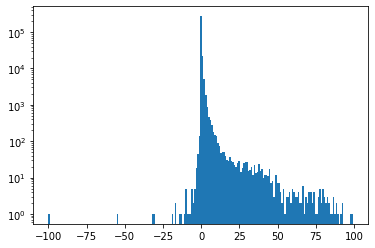

In [9]:
plt.hist(diffs[~np.isnan(diffs)], bins = 200);
plt.yscale('log', nonposy='clip')

### We use the scraped cast, the scraped movies and the movie files to get an average age of each cast 

In [76]:
def split_profession(str):
    return str.split(',')

In [77]:
people_df = pd.read_csv('./data/name.basics.tsv.gz', sep='\t', converters={'primaryProfession': split_profession},\
                        na_values= '\\N')

In [78]:
people_df = people_df.explode('primaryProfession')

In [79]:
#people_df = people_df[(people_df['primaryProfession'] == 'actor') | (people_df['primaryProfession'] == 'actress')]

In [80]:
cast = pd.read_pickle('complete_cast.pkl')

In [81]:
cast = cast.explode('cast')

In [82]:
people_df_year = people_df.drop(['primaryName', 'deathYear', 'primaryProfession', 'knownForTitles'], axis=1)

In [83]:
cast = cast.merge(people_df_year, how='inner', left_on = 'cast', right_on = 'nconst')

In [84]:
movies['Year'] = np.where(np.isnan(movies['startYear']), movies['testYear'], movies['startYear'])

In [85]:
movies_year = movies[['tconst', 'Year']]

In [86]:
cast = cast.merge(movies_year, how='inner', on = 'tconst')

There is a lot of duplicates after all those merges

In [87]:
cast['cast'].isna().sum()

0

In [88]:
cast['tconst'].isna().sum()

0

In [89]:
(cast[['tconst', 'cast']].duplicated()).sum()

4120666

In [90]:
cast = cast.drop_duplicates(subset=['tconst', 'cast'])

###### We remove the obvious outliers like birthYear < 1800

In [91]:
cast['birthYear'] = np.where(cast['birthYear'] < 1800, np.nan, cast['birthYear'])

In [92]:
cast['Age'] = cast['Year'] - cast['birthYear']

In [93]:
ages = cast['Age'].values

In [94]:
(cast['Age'] < 0).sum()

530

In [95]:
(cast['Age'] > 100).sum()

6737

In [96]:
cast[cast['Age'] < 0]

,tconst,cast,count,nconst,birthYear,Year,Age
68268,tt0447263,nm1294583,11,nm1294583,1962.0,1960.0,-2.0
88066,tt0104252,nm0572986,52,nm0572986,1992.0,1991.0,-1.0
113164,tt0071673,nm1013094,26,nm1013094,1977.0,1974.0,-3.0
122850,tt0273315,nm0951004,20,nm0951004,1969.0,1966.0,-3.0
144939,tt8761880,nm1001002,3,nm1001002,1985.0,1970.0,-15.0
...,...,...,...,...,...,...,...
10646958,tt0015667,nm0317854,4,nm0317854,1977.0,1926.0,-51.0
10651352,tt8763656,nm1001035,1,nm1001035,1970.0,1965.0,-5.0
10731075,tt8771062,nm1001408,1,nm1001408,1979.0,1966.0,-13.0
10786228,tt0064634,nm1093879,3,nm1093879,1986.0,1969.0,-17.0


In [97]:
cast[cast['Age'] > 100]

,tconst,cast,count,nconst,birthYear,Year,Age
7022,tt8885602,nm1006813,6,nm1006813,1881.0,2011.0,130.0
25937,tt0118694,nm0208540,16,nm0208540,1890.0,2000.0,110.0
40435,tt3180122,nm0855602,86,nm0855602,1912.0,2017.0,105.0
40461,tt3180122,nm0000060,86,nm0000060,1916.0,2017.0,101.0
40485,tt3180122,nm0580565,86,nm0580565,1907.0,2017.0,110.0
...,...,...,...,...,...,...,...
10793739,tt8237250,nm1013661,1,nm1013661,1890.0,2018.0,128.0
10794325,tt6714954,nm1057706,5,nm1057706,1892.0,2019.0,127.0
10795797,tt11090844,nm0046035,1,nm0046035,1910.0,2013.0,103.0
10795834,tt11112696,nm1105325,1,nm1105325,1886.0,2019.0,133.0


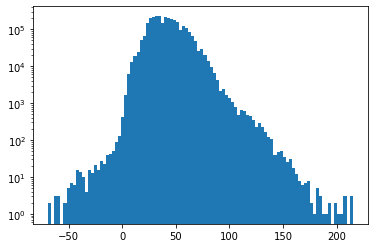

In [98]:
ages = cast['Age'].values
plt.hist(ages[~np.isnan(ages)], bins=100);
plt.yscale('log', nonposy='clip')

#### We use the median age of the cast instead of the mean and see if it gives credible results

In [377]:
def custom_median(cast_age):
    return np.median(cast_age[~np.isnan(cast_age)])

def custom_mean(cast_age):
    return np.mean(cast_age[~np.isnan(cast_age)])

def cast_count(cast_age):
    return len(cast_age[~np.isnan(cast_age)])

In [100]:
cast_ages = cast.groupby(['tconst'])['Age'].agg([custom_median, cast_count])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [101]:
cast_ages.head()

,custom_median,cast_count
tconst,,
tt0000009,19.0,3.0
tt0000147,39.0,5.0
tt0000335,11.0,2.0
tt0000502,NaN,0.0
tt0000574,28.0,6.0


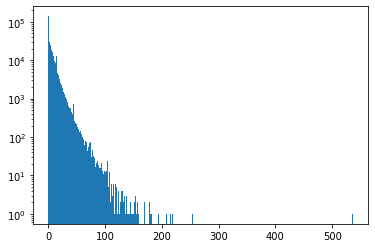

In [109]:
plt.hist(cast_ages['cast_count'], bins=500);
plt.yscale('log', nonposy='clip')

We only take into the median where we have more than 10 persons in the cast

In [103]:
cast_ages['credible_median'] = np.where(cast_ages['cast_count'] > 10, cast_ages['custom_median'], np.nan)

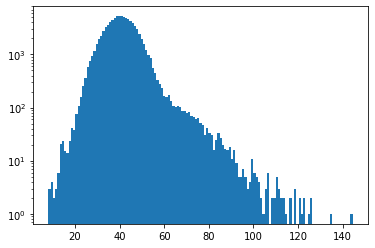

In [128]:
credible_median_ages = cast_ages['credible_median'].values
plt.hist(credible_median_ages[~np.isnan(credible_median_ages)], bins = 135);
plt.yscale('log', nonposy='clip')

In [105]:
cast_ages.nlargest(10, 'credible_median')

,custom_median,cast_count,credible_median
tconst,,,
tt6454944,144.5,30.0,144.5
tt6490038,135.0,11.0,135.0
tt1646939,126.0,11.0,126.0
tt3587202,126.0,17.0,126.0
tt0212457,125.0,11.0,125.0
tt3188516,123.0,13.0,123.0
tt3526810,123.0,13.0,123.0
tt10443162,122.0,43.0,122.0
tt2161168,121.0,20.0,121.0


In [106]:
cast_ages.nsmallest(10, 'credible_median')

,custom_median,cast_count,credible_median
tconst,,,
tt0201347,8.0,27.0,8.0
tt0008144,9.0,17.0,9.0
tt0110366,9.0,34.0,9.0
tt0007617,9.5,14.0,9.5
tt0009721,9.5,14.0,9.5
tt0117008,10.0,44.0,10.0
tt0124879,10.0,35.0,10.0
tt0007669,11.0,14.0,11.0
tt0022397,11.0,16.0,11.0


In [133]:
OSCAR_WEIGHT = 10
WIN_WEIGHT = 2
NOMINATION_WEIGHT = 1
movies['recognition'] = (movies.oscarWins * OSCAR_WEIGHT) + (movies.nominations * NOMINATION_WEIGHT) + (movies.wins *WIN_WEIGHT)
recognized_movies = movies.sort_values('recognition', ascending=False)
recognized_movies

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,musicProducer,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,testYear,Year,recognition
137270,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,nm0001877,12 Years a Slave,12 Years a Slave,0.0,2013.0,134.0,NaN,2014.0,2013.0,836
532918,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,nm3225654,La La Land,La La Land,0.0,2016.0,128.0,NaN,2016.0,2016.0,794
523662,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,nm1615109,Moonlight,Moonlight,0.0,2016.0,111.0,NaN,2016.0,2016.0,757
9395,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,nm0432725,Mad Max: Fury Road,Mad Max: Fury Road,0.0,2015.0,120.0,NaN,2015.0,2015.0,744
125615,tt1454468,"[nm0000113, nm0000123, nm0000438]",7,177,233,2013-10-23,France,"[female protagonist, space station, sole survi...","$100,000,000","$723,192,705",...,nm1888527,Gravity,Gravity,0.0,2013.0,91.0,NaN,2013.0,2013.0,713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189271,tt0054356,"[nm0088946, nm0127113, nm0353757]",0,0,0,1961-01-20,Finland,[],None,None,...,nm0286769,Susanne,Susanne,0.0,1960.0,87.0,NaN,1961.0,1960.0,0
189270,tt0054308,"[nm0310618, nm0865063, nm0051060]",0,0,0,1960-11-23,Yugoslavia,[],None,None,...,nm0010650,Signal Over the City,Signali nad gradom,0.0,1960.0,91.0,NaN,1960.0,1960.0,0
189268,tt0054304,"[nm0496856, nm0466977, nm0266949]",0,0,0,1961-03-11,Italy,[],None,None,...,nm0630466,Blood Feud,Il sicario,0.0,1961.0,87.0,NaN,1961.0,1961.0,0
189267,tt0054332,[],0,0,0,None,None,[],None,None,...,None,Spartakiáda,Spartakiáda,0.0,1956.0,88.0,NaN,NaN,1956.0,0


In [135]:
recognized_movies = recognized_movies.merge(cast_ages, how='left', left_on='tconst', right_index=True)

In [333]:
recognized_movies = recognized_movies.drop_duplicates(subset=['tconst'])

In [334]:
recognized_movies.head()

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,genres,testYear,Year,recognition,custom_median,cast_count,credible_median,averageRating,numVotes,worldwideGross_adjusted
0,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,NaN,2014.0,2013.0,836,42.5,32.0,42.5,8.1,590369.0,2.023595e+08
2,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,NaN,2016.0,2016.0,794,36.5,54.0,36.5,8.0,451658.0,4.667229e+08
3,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,NaN,2016.0,2016.0,757,37.0,5.0,NaN,7.4,237473.0,6.805492e+07
4,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,NaN,2015.0,2015.0,744,40.0,25.0,40.0,8.1,802392.0,3.975142e+08
6,tt1454468,"[nm0000113, nm0000123, nm0000438]",7,177,233,2013-10-23,France,"[female protagonist, space station, sole survi...","$100,000,000","$723,192,705",...,NaN,2013.0,2013.0,713,53.0,4.0,NaN,7.7,724190.0,7.795368e+08


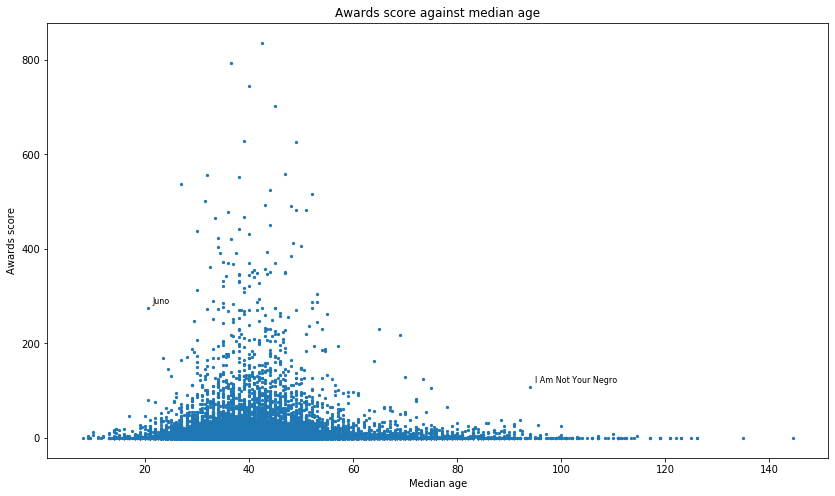

In [335]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against median age") 

annotations = []
annotations.append(recognized_movies[(recognized_movies['credible_median'] < 25) &\
                  (recognized_movies['recognition'] > 200)]\
                 [['primaryTitle', 'credible_median', 'recognition']].values[0])
annotations.append(recognized_movies[(recognized_movies['credible_median'] > 90) &\
                  (recognized_movies['recognition'] > 100)]\
                 [['primaryTitle', 'credible_median', 'recognition']].values[0])

for title, x, y in annotation:
    plt.text(x+1, y+10, title, fontsize=8)

#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Awards score');

In [173]:
movie_ratings = pd.read_csv("./data/title.ratings.tsv.gz", sep='\t')

In [177]:
recognized_movies = recognized_movies.merge(movie_ratings, on='tconst', how='left')

In [336]:
recognized_movies = recognized_movies.drop_duplicates(subset=['tconst'])

In [178]:
recognized_movies.head()

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,runtimeMinutes,genres,testYear,Year,recognition,custom_median,cast_count,credible_median,averageRating,numVotes
0,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,134.0,NaN,2014.0,2013.0,836,42.5,32.0,42.5,8.1,590369.0
1,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,134.0,NaN,2014.0,2013.0,836,42.5,32.0,42.5,8.1,590369.0
2,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,128.0,NaN,2016.0,2016.0,794,36.5,54.0,36.5,8.0,451658.0
3,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,111.0,NaN,2016.0,2016.0,757,37.0,5.0,NaN,7.4,237473.0
4,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,120.0,NaN,2015.0,2015.0,744,40.0,25.0,40.0,8.1,802392.0


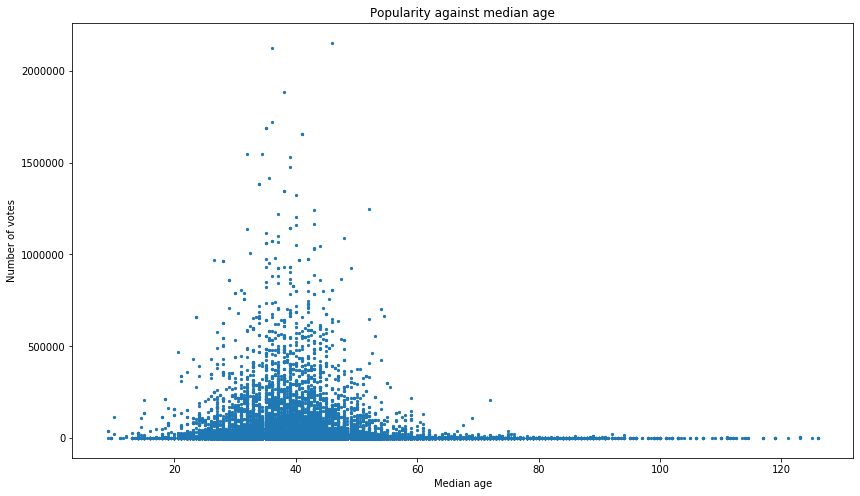

In [250]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['numVotes'], s=5);

plt.title("Popularity against median age")  
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Number of votes');

In [230]:
def keep_numbers(revenue):
    """Function to convert revenue string to a number, we only do it for revenue in dollars
    Because we did not manage to find conversion rates for movies from <2000"""
    if revenue == None or revenue[0] != '$':
        return np.nan
    return int(re.sub("[^0-9]","", str(revenue)))

recognized_movies['worldwideGross_adjusted'] = recognized_movies['worldwideGross'].apply(keep_numbers)

In [244]:
def normalize_inflation(revenue, year):
    """Take inflation into account, no data available before 1960 """
    if np.isnan(revenue) or np.isnan(year) or year < 1960:
        return np.nan
    return ep.normalize(amount=revenue, region="US", from_year=year, to_year="latest", base_currency="USD")
ep = EasyPeasy()
normalize_inflation = np.vectorize(normalize_inflation)

recognized_movies['worldwideGross_adjusted'] = normalize_inflation(recognized_movies['worldwideGross_adjusted'],\
                                                                   recognized_movies['Year'])

/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 2022.0 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2018.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 2020.0 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2018.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


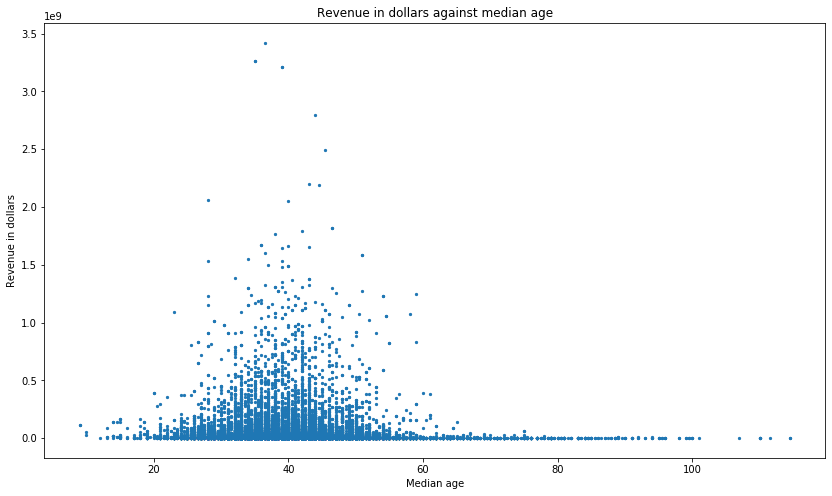

In [252]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against median age")
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Revenue in dollars');

# Metacritic score

In [259]:
clean_metascore = [lambda x: np.nan if x == None else int(x)]
recognized_movies['metascore'] = recognized_movies['metascore'].apply(clean_metascore)

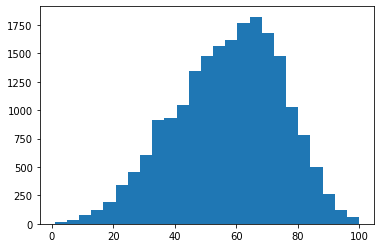

In [279]:
plt.hist(recognized_movies['metascore'], bins = 25);

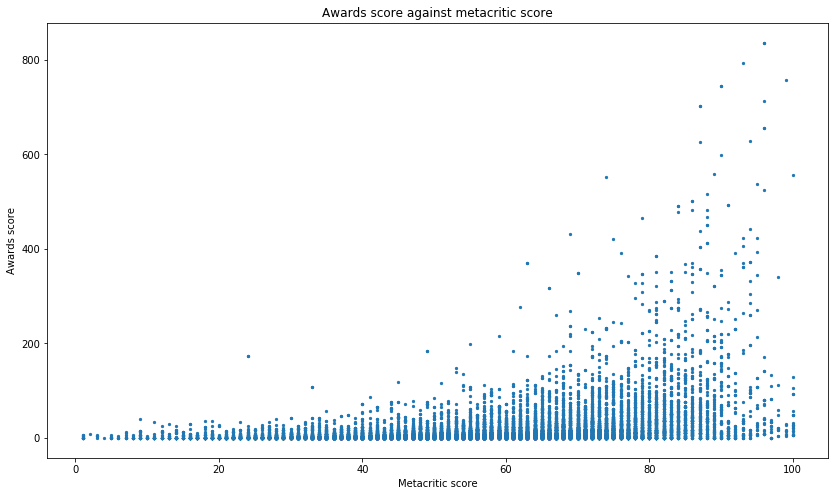

In [283]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against metacritic score")   
#plt.yscale('symlog')
plt.xlabel('Metacritic score')
plt.ylabel('Awards score');

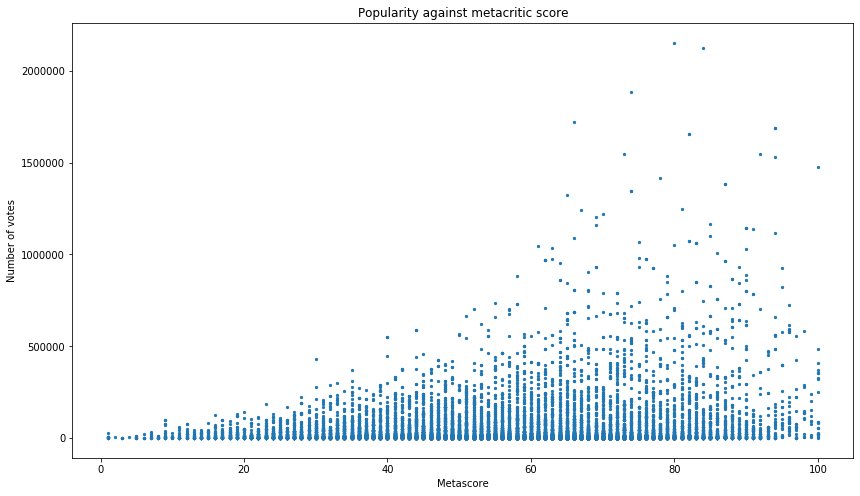

In [287]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['numVotes'], s=5);

plt.title("Popularity against metacritic score")  
#plt.yscale('symlog')
plt.xlabel('Metascore')
plt.ylabel('Number of votes');

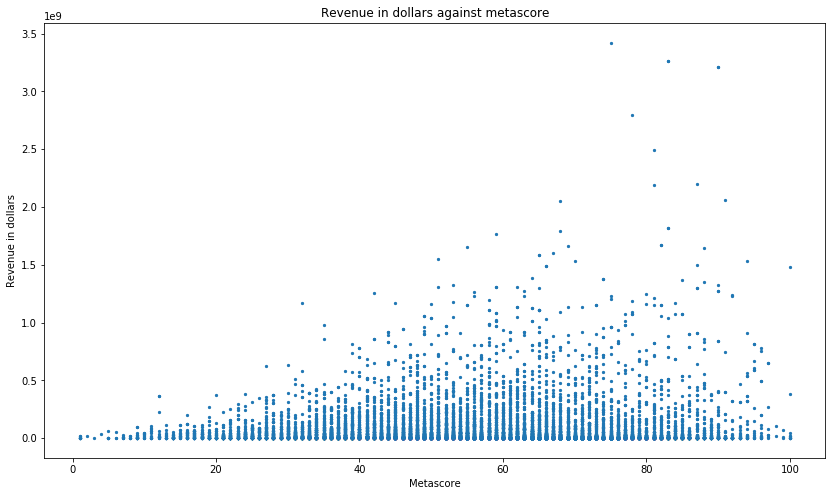

In [288]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against metascore")
#plt.yscale('symlog')
plt.xlabel('Metascore')
plt.ylabel('Revenue in dollars');

# isAdult

In [379]:
recognized_movies.groupby('isAdult')['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([custom_mean, custom_median, cast_count])

recognition                              numVotes                \
        custom_mean custom_median cast_count  custom_mean custom_median   
isAdult                                                                   
0.0        1.170788             0     525757  3283.677676          48.0   
1.0        0.137336             0       8694    41.642911          15.0   

                   worldwideGross_adjusted                           
        cast_count             custom_mean custom_median cast_count  
isAdult                                                              
0.0       236458.0            2.180524e+07     494475.35    43376.0  
1.0         4013.0            8.288359e+04      24874.76        7.0

# runtimeMinutes

In [415]:
length_success = recognized_movies[['tconst', 'primaryTitle', 'runtimeMinutes', 'recognition', \
                                    'numVotes', 'worldwideGross_adjusted']]

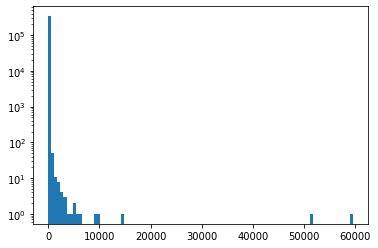

In [416]:
plt.hist(length_success['runtimeMinutes'], bins = 100);
plt.yscale('log', nonposy='clip')

In [417]:
length_success.nlargest(10, 'runtimeMinutes')[['tconst','primaryTitle', 'runtimeMinutes']]

,tconst,primaryTitle,runtimeMinutes
399886,tt10844584,100,59460.0
100142,tt8273150,Logistics,51420.0
377635,tt2659636,Modern Times Forever,14400.0
399880,tt10844900,Qw,10062.0
339117,tt2355497,Beijing 2003,9000.0
106922,tt5068890,Hunger!,6000.0
118228,tt5136218,London EC1,5460.0
100633,tt0284020,The Cure for Insomnia,5220.0
308148,tt5240738,Ember Glow,4980.0
394026,tt1735956,Deregulation,4200.0


Even the values are legit, we remove the outliers

In [426]:
length_success = length_success[length_success['runtimeMinutes'] < 250]

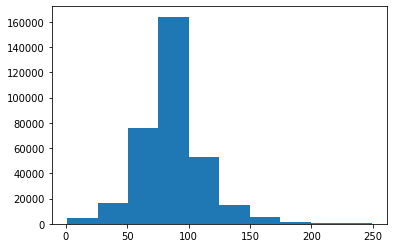

In [430]:
plt.hist(length_success['runtimeMinutes']);
#plt.yscale('log', nonposy='clip')

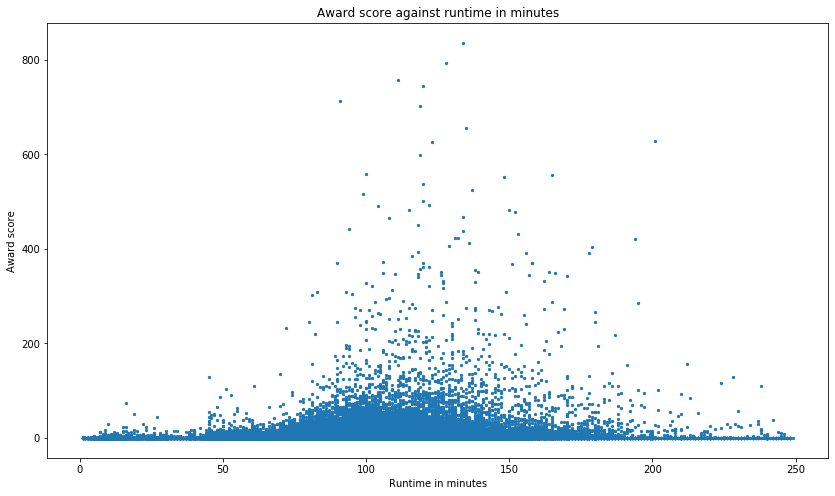

In [431]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['recognition'], s=5);

plt.title("Award score against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Award score');

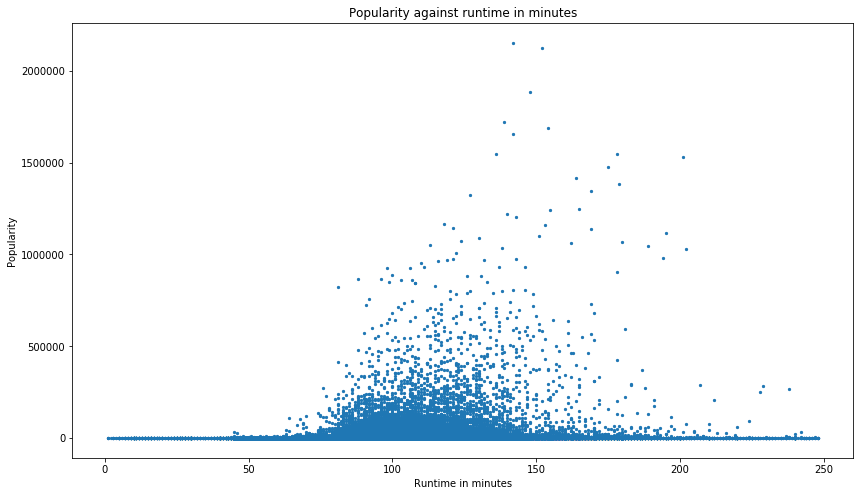

In [432]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['numVotes'], s=5);

plt.title("Popularity against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Popularity');

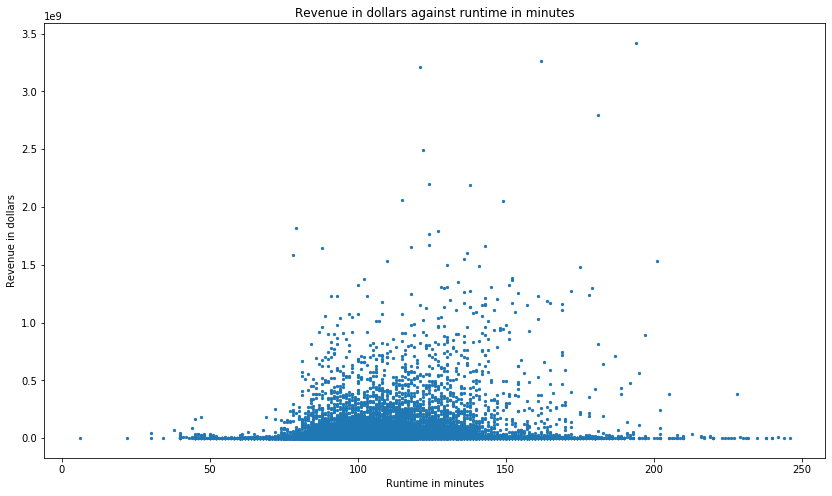

In [433]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Revenue in dollars');

# plotKeywords

In [342]:
top_keywords = recognized_movies.explode('plotKeywords')

In [381]:
top_keywords['plotKeywords'].value_counts()

female nudity            690
female frontal nudity    413
male frontal nudity      340
nudity                   267
male nudity              265
                        ... 
ted bundy                  1
sex in a confessional      1
sequel to cult film        1
french colony              1
emergency brake            1
Name: plotKeywords, Length: 15590, dtype: int64

# Frequency of each award

In [434]:
recognized_movies['oscarWins'].sum()

1108

In [436]:
recognized_movies['wins'].sum()

182540

In [437]:
recognized_movies['nominations'].sum()

240716

In [438]:
OSCAR_WEIGHT = 1108 / recognized_movies['oscarWins'].sum()
WIN_WEIGHT = 1108 / recognized_movies['wins'].sum()
NOMINATION_WEIGHT = 1108 / recognized_movies['nominations'].sum()
movies['recognition2'] = (movies.oscarWins * OSCAR_WEIGHT) + (movies.nominations * NOMINATION_WEIGHT) + (movies.wins *WIN_WEIGHT)
recognized_movies2 = movies.sort_values('recognition2', ascending=False)
recognized_movies2

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,testYear,Year,recognition,recognition2
253088,tt0167260,"[nm0000704, nm0001557, nm0005212]",11,122,198,2003-12-17,Sweden,"[orc, epic, battle, journey, hobbit]","$94,000,000","$1,120,424,614",...,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0.0,2003.0,201.0,NaN,2003.0,2003.0,628,12.763399
236609,tt0120338,"[nm0000138, nm0000701, nm0000708]",11,80,115,1997-12-19,USA,"[iceberg, told in flashback, titanic, ship, sh...","$200,000,000","$2,187,463,944",...,Titanic,Titanic,0.0,1997.0,194.0,NaN,1997.0,1997.0,420,12.066274
187906,tt0052618,"[nm0000032, nm0370144, nm0000963]",11,13,17,1960-10-06,Netherlands,"[roman empire, ancient rome, roman, revenge, c...","$15,000,000","$74,427,638",...,Ben-Hur,Ben-Hur,0.0,1959.0,212.0,NaN,1960.0,1959.0,157,11.163026
244527,tt0055614,"[nm0000081, nm0001995, nm0000937]",10,10,18,1962-03-29,Netherlands,[],"$6,000,000","$44,061,777",...,West Side Story,West Side Story,0.0,1961.0,153.0,NaN,1962.0,1961.0,146,10.155288
234175,tt0116209,"[nm0000146, nm0000300, nm0000353]",9,75,54,1996-12-06,USA,"[patient, nurse, flashback, english, church, d...","$27,000,000","$231,976,425",...,The English Patient,The English Patient,0.0,1996.0,162.0,NaN,1996.0,1996.0,273,9.672995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189271,tt0054356,"[nm0088946, nm0127113, nm0353757]",0,0,0,1961-01-20,Finland,[],None,None,...,Susanne,Susanne,0.0,1960.0,87.0,NaN,1961.0,1960.0,0,0.000000
189270,tt0054308,"[nm0310618, nm0865063, nm0051060]",0,0,0,1960-11-23,Yugoslavia,[],None,None,...,Signal Over the City,Signali nad gradom,0.0,1960.0,91.0,NaN,1960.0,1960.0,0,0.000000
189268,tt0054304,"[nm0496856, nm0466977, nm0266949]",0,0,0,1961-03-11,Italy,[],None,None,...,Blood Feud,Il sicario,0.0,1961.0,87.0,NaN,1961.0,1961.0,0,0.000000
189267,tt0054332,[],0,0,0,None,None,[],None,None,...,Spartakiáda,Spartakiáda,0.0,1956.0,88.0,NaN,NaN,1956.0,0,0.000000


In [441]:
recognized_movies2 = recognized_movies2.merge(cast_ages, how='left', left_on='tconst', right_index=True)
recognized_movies2 = recognized_movies2.drop_duplicates(subset=['tconst'])

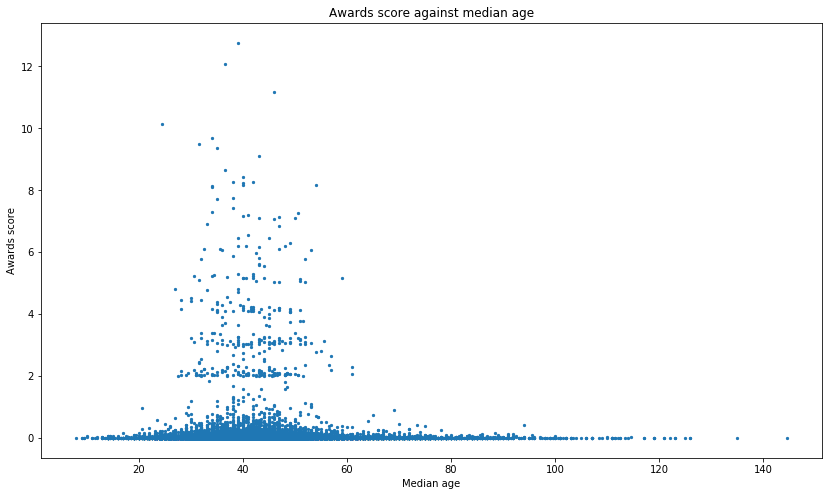

In [443]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies2['credible_median'],\
            recognized_movies2['recognition2'], s=5);
plt.title("Awards score against median age") 


#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Awards score');

In [444]:
recognized_movies2['metascore'] = recognized_movies2['metascore'].apply(clean_metascore)

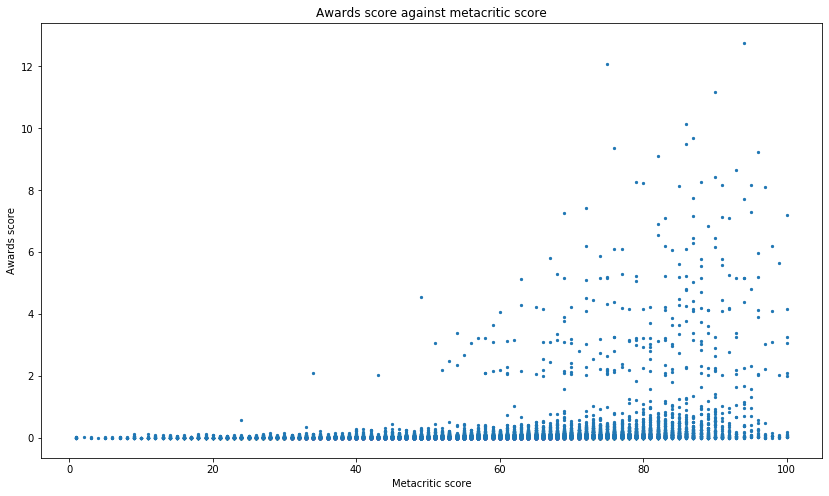

In [446]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies2['metascore'],\
            recognized_movies2['recognition2'], s=5);
plt.title("Awards score against metacritic score")   
#plt.yscale('symlog')
plt.xlabel('Metacritic score')
plt.ylabel('Awards score');

In [449]:
recognized_movies2.groupby('isAdult')['recognition2']\
                 .agg([custom_mean, custom_median, cast_count])

,custom_mean,custom_median,cast_count
isAdult,,,
0.0,0.006313,0.0,525757.0
1.0,0.000492,0.0,8694.0


In [450]:
recognized_movies.to_pickle("recognized_movies.pkl")